In [1]:
import nibabel as nib
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import random
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
from glob import glob
from PIL import Image
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader
from torchsummary import summary
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

## Data Processing and Exploration

### Choosing the right data:

The full dataset has been processed from it's original 350GB+ MRI dataset. The original csv file is filtered to include only 1.5T or 3.0T scans as they contain the most comprehensive sets of MRI scans of differing types (T1-weighted, T2, Bold, etc). 

The clinical dementia rating (cdr) with values (0, 0.5, 1, 2) represent 0 = absent; 0.5 = questionable; 1= present, but mild; 2 = moderate (reference: https://www.sciencedirect.com/topics/neuroscience/clinical-dementia-rating). They have been remapped from (0, 0.5, 1, 2) to (0, 1, 2, 3) due to issues processing it with Torch dataloader, leading to a missing class for 0.5 cdr.

Based on each MRI session value (Label), if there are multiple values for the cdr then the scans are excluded.

In [2]:
diagnostic_file = glob('diagnosis.csv')[0]

diagnostic_df = pd.read_csv(diagnostic_file)

diagnostic_df = diagnostic_df[(diagnostic_df.Scanner == '3.0T') | (diagnostic_df.Scanner == '1.5T')]

multiple_values = diagnostic_df.groupby('Label').filter(lambda group: group['cdr'].nunique() > 1)['Label'].unique()

cdr_map = {0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3}

# Filter out rows with these values in column A
filtered_diagnostic_df = diagnostic_df[~diagnostic_df['Label'].isin(multiple_values)]
filtered_diagnostic_df = filtered_diagnostic_df.drop_duplicates(subset='Label')
# filtered_diagnostic_df['cdr'] = filtered_diagnostic_df['cdr'].map(cdr_map)
filtered_diagnostic_df['file_tag'] = filtered_diagnostic_df.Label.apply(lambda file_name: file_name[-5:])
print(len(filtered_diagnostic_df))

valid_mr_scans_ls = filtered_diagnostic_df.file_tag.to_list()
print(valid_mr_scans_ls[:3])
filtered_diagnostic_df.file_tag

# filtered_diagnostic_df.to_csv('filtered_data.csv')

1379
['d0129', 'd2430', 'd3132']


0       d0129
2       d2430
3       d3132
12      d0371
15      d2340
        ...  
6193    d0148
6194    d2526
6195    d1566
6216    d1717
6217    d0407
Name: file_tag, Length: 1379, dtype: object

This section is to preview the different MRI images available.

['sub-OAS30001_ses-d0757_acq-TSE_T2w.nii.gz', 'sub-OAS30001_ses-d0757_run-01_T1w.nii.gz', 'sub-OAS30001_ses-d0757_run-02_T1w.nii.gz', 'sub-OAS30001_ses-d0757_T2star.nii.gz', 'sub-OAS30001_ses-d0757_T2w.nii.gz', 'sub-OAS30001_ses-d0757_dwi.nii.gz', 'sub-OAS30001_ses-d0757_task-rest_run-01_bold.nii.gz', 'sub-OAS30001_ses-d0757_task-rest_run-02_bold.nii.gz', 'sub-OAS30001_ses-d0757_minIP.nii.gz', 'sub-OAS30001_ses-d0757_swi.nii.gz']


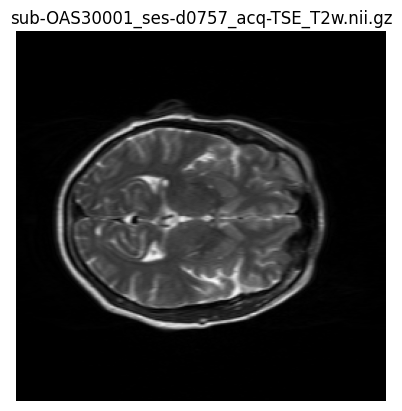

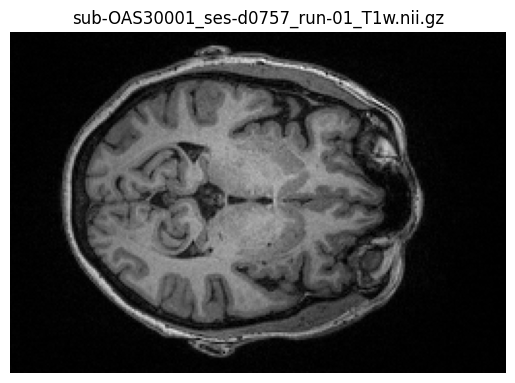

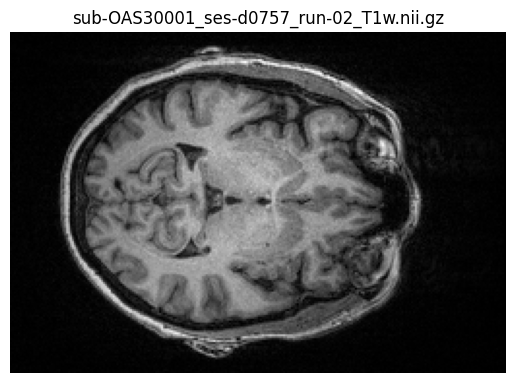

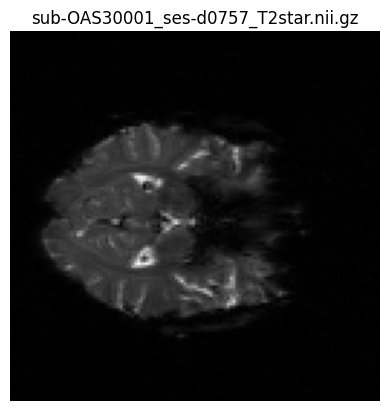

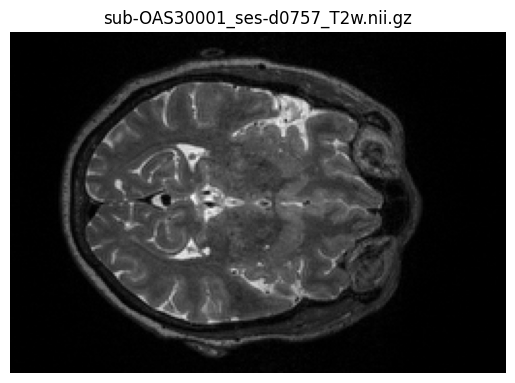

Cannot show: D:/DL/bids/sub-OAS30001/ses-d0757\dwi\sub-OAS30001_ses-d0757_dwi.nii.gz
Cannot show: D:/DL/bids/sub-OAS30001/ses-d0757\func\sub-OAS30001_ses-d0757_task-rest_run-01_bold.nii.gz
Cannot show: D:/DL/bids/sub-OAS30001/ses-d0757\func\sub-OAS30001_ses-d0757_task-rest_run-02_bold.nii.gz


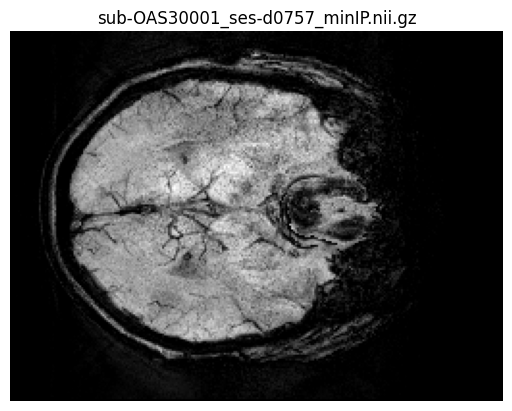

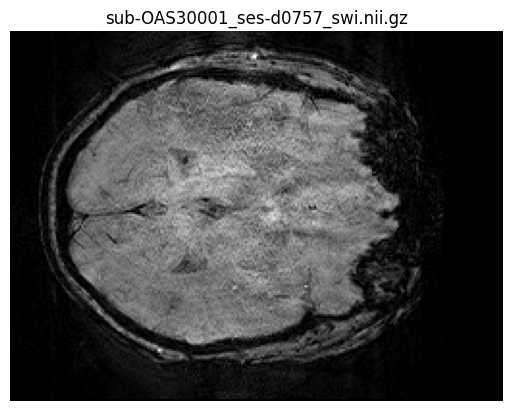

In [3]:
def display_nii_gz_files(file_path):
    # List all files in the given directory
    nii_gz_files = glob(file_path + '/**/*nii.gz', recursive=True)
    
    file_names = [file.split('\\')[-1] for file in nii_gz_files]
    print(file_names)
    # Display each .nii.gz file
    for file_name in nii_gz_files:
        try:
            img = nib.load(file_name)
            data = img.get_fdata()
            
            # Display a middle slice of the 3D image
            slice_index = data.shape[2] // 2
            plt.imshow(data[:, :, slice_index], cmap='gray')
            plt.title(file_name.split('\\')[-1])
            plt.axis('off')
            plt.show()
        except:
            print(f'Cannot show: {file_name}')

# Example usage
display_nii_gz_files('D:/DL/bids/sub-OAS30001/ses-d0757/')


Based on research, T1-weighted scans are one of the most widely used datasets for predicting and diagnosing dementia. It provides extremely detailed assessments of the brain's structure which can be used to find out the presence or absence, as well as the pattern for brain volume loss such as atrophy. Hence, below is the file retrieval for T1-weighted scans.

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3486423/#:~:text=T1%20weighted%20volumetric%20MRI%20scanning,volume%20loss%2C%20ie%2C%20atrophy.

In [4]:
data_path = 'D:/DL/bids/' ## Change as needed

def recursive_glob_with_filter(directory, filter_list):
    # Use recursive glob pattern to find all files
    all_files = glob(directory + '/**/*T1*nii.gz', recursive=True)
    
    # Filter files based on the presence of strings from filter_list in the file path
    filtered_files = [file for file in all_files if any(filter_str in file for filter_str in filter_list)]
    
    return filtered_files

file_ls = recursive_glob_with_filter(data_path, valid_mr_scans_ls)
print(file_ls[:2])

['D:/DL/bids\\sub-OAS30001\\ses-d0129\\anat\\sub-OAS30001_ses-d0129_run-01_T1w.nii.gz', 'D:/DL/bids\\sub-OAS30001\\ses-d0129\\anat\\sub-OAS30001_ses-d0129_run-02_T1w.nii.gz']


In [5]:
# from nilearn import plotting

# nifti_file_path = file_ls[8]
# img = nib.load(nifti_file_path)
# data = img.get_fdata()

# # Display a single slice
# scan = data[:, :, data.shape[2] // 2]
# plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')
# plt.show()
# print(scan.shape) #(176, 256, 256)
# plt.imshow(scan)

# # Display the anatomical image
# plotting.plot_anat(nifti_file_path)
# plotting.show()

# # Interactive plotting
# plotting.view_img(img, bg_img=False, cmap='gray')

# # Plotting multiple slices
# plotting.plot_anat(nifti_file_path, display_mode='ortho', cut_coords=(30, -40, 10), cmap='gray')


In [6]:
# Function to extract tag from file path
def extract_tag_from_file_path(file_path):
    file_path = file_path.replace(data_path[:-1], '')
    return file_path.split('\\')[2][-5:]

try:
    data_loader_df = pd.read_csv('data_loader_df.csv')
except:
    # Create a new DataFrame to store the results
    data_loader_df = pd.DataFrame(columns=['file_path', 'label'])

    # Iterate over the file list and find the corresponding CDR value
    for file_path in file_ls:
        tag = extract_tag_from_file_path(file_path)
        cdr_value = filtered_diagnostic_df.loc[filtered_diagnostic_df['file_tag'] == tag, 'cdr'].values
        if cdr_value.size > 0:  # Check if cdr_value is not empty
            new_row = pd.DataFrame({'file_path': [file_path], 'label': [cdr_value[0]]})
            data_loader_df = pd.concat([data_loader_df, new_row], ignore_index=True)
            data_loader_df.to_csv('data_loader_df.csv')

print(data_loader_df)

      Unnamed: 0                                          file_path  label
0              0  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
1              1  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
2              2  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
3              3  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
4              4  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
...          ...                                                ...    ...
2991        2991  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
2992        2992  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    1.0
2993        2993  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
2994        2994  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.5
2995        2995  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0

[2996 rows x 3 columns]


This section is to extract 2D slices from 3D volumetric MRI scans. It iterates through the T1-weighted scans and slices between indexes 100-160, choosing a slice for every 3 slices. If the scan has less then 160 slices, then the middle slice will be taken of which there is only 1. Eventually there should be a dataset of 58,376. 

JPG is the saved file format due to its smaller size. NPY was tried but was 840GB and hence rejected.

**Run only once (roughly 7-20 mins depending on CPU).**

In [7]:
'''## For image generation. Please do not delete

# Define the mapping from old labels to new labels
label_mapping = {0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3}

# Apply the mapping to the 'label' column
data_loader_df['label'] = data_loader_df['label'].map(label_mapping)

def img_preprocessing(img):
    # Normalize the image
    normalized_image = (img - np.min(img)) / (np.max(img) - np.min(img))

    # Determine the scaling factor based on the longest edge
    scaling_factor = 224 / max(normalized_image.shape)
    rescaled_size = (int(normalized_image.shape[1] * scaling_factor), int(normalized_image.shape[0] * scaling_factor))
    rescaled_image = cv2.resize(normalized_image, rescaled_size, interpolation=cv2.INTER_LINEAR)

    # Calculate padding sizes
    pad_height = (224 - rescaled_image.shape[0]) // 2
    pad_width = (224 - rescaled_image.shape[1]) // 2

    # Pad the image to 224x224
    padded_image = np.pad(rescaled_image, ((pad_height, 224 - rescaled_image.shape[0] - pad_height), (pad_width, 224 - rescaled_image.shape[1] - pad_width)), 'constant', constant_values=0)

    # Convert to RGB by repeating the single channel 3 times
    rgb_image = np.repeat(padded_image[:, :, np.newaxis], 3, axis=2)

    return rgb_image

def preprocess_and_save(df, save_dir):
    for i in range(len(df)):
        nifti_file_path, label = df.iloc[i]
        img = nib.load(nifti_file_path)
        data = img.get_fdata()

        try:
            for slice_index in range(100, 161, 3):  # Save slices from 100 to 160
                scan = data[:, :, slice_index]
                preprocessed_scan = img_preprocessing(scan)
                save_path = os.path.join(save_dir, f"label_{label}_idx_{i}_slice_{slice_index}.jpg")
                cv2.imwrite(save_path, preprocessed_scan * 255)  # Multiply by 255 to convert from [0, 1] to [0, 255] range

        except:
            scan = data[:, :, data.shape[2] // 2]
            preprocessed_scan = img_preprocessing(scan)
            save_path = os.path.join(save_dir, f"label_{label}_idx_{i}.jpg")
            cv2.imwrite(save_path, preprocessed_scan * 255)  # Multiply by 255 to convert from [0, 1] to [0, 255] range

save_dir = data_path[:-5] + "preprocessed_images"
print(save_dir)
os.makedirs(save_dir, exist_ok=True)
preprocess_and_save(data_loader_df, save_dir)
'''

'## For image generation. Please do not delete\n\n# Define the mapping from old labels to new labels\nlabel_mapping = {0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3}\n\n# Apply the mapping to the \'label\' column\ndata_loader_df[\'label\'] = data_loader_df[\'label\'].map(label_mapping)\n\ndef img_preprocessing(img):\n    # Normalize the image\n    normalized_image = (img - np.min(img)) / (np.max(img) - np.min(img))\n\n    # Determine the scaling factor based on the longest edge\n    scaling_factor = 224 / max(normalized_image.shape)\n    rescaled_size = (int(normalized_image.shape[1] * scaling_factor), int(normalized_image.shape[0] * scaling_factor))\n    rescaled_image = cv2.resize(normalized_image, rescaled_size, interpolation=cv2.INTER_LINEAR)\n\n    # Calculate padding sizes\n    pad_height = (224 - rescaled_image.shape[0]) // 2\n    pad_width = (224 - rescaled_image.shape[1]) // 2\n\n    # Pad the image to 224x224\n    padded_image = np.pad(rescaled_image, ((pad_height, 224 - rescaled_image.shap

Due to an extremely imbalanced dataset (Label 0.0: 50216; Label 1.0: 5748; Label 2.0: 1971; Label 3.0: 441), weights will be used. 

In [8]:
from collections import defaultdict
import os
import pandas as pd
import torch

save_dir = data_path[:-5] + "preprocessed_images"
# Dictionary to store the count of each label
class_counts = defaultdict(int)

# List to store file paths and labels
file_paths_labels = []

# Iterate over all files in the save directory
for filename in os.listdir(save_dir):
    if filename.startswith("label_") and filename.endswith(".jpg"):
        # Extract the label from the filename and convert it to a decimal (float)
        label = float(filename.split("_")[1])
        # Increment the count for this label
        class_counts[label] += 1
        # Append the full file path and label to the list
        full_path = os.path.join(save_dir, filename)
        file_paths_labels.append((full_path, label))

dementia_count = 0
healthy_count = 0
# Print the count of each label
for label, count in class_counts.items():
    print(f"Label {label}: {count}")
    if label >0:
        dementia_count+=count
    else:
        healthy_count+=count
# Create a DataFrame from the list of file paths and labels
jpg_data_loader_df = pd.DataFrame(file_paths_labels, columns=['file_path', 'label'])

## Print the first few rows of the DataFrame
# print(jpg_data_loader_df.head())

# Calculate weights: Inverse of the frequency seems like a simple choice
total_count = sum(class_counts.values())
weights = {k: total_count / v for k, v in class_counts.items()}
print(weights)
# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert weights to a tensor, ensuring the labels are in the correct order
weights_tensor = torch.tensor([weights[0], weights[1], weights[2], weights[3]], dtype=torch.float32)

print(weights_tensor)
weights_tensor = weights_tensor.to(device)
jpg_data_loader_df.to_csv('jpg_data_loader_df.csv')

all_dementia_weight = (healthy_count+dementia_count)/dementia_count
# all_dementia_weight = 3
print(all_dementia_weight)


Label 0.0: 50216
Label 1.0: 5748
Label 2.0: 1971
Label 3.0: 441
{0.0: 1.1624980086028358, 1.0: 10.155880306193458, 2.0: 29.617453069507864, 3.0: 132.3718820861678}
tensor([  1.1625,  10.1559,  29.6175, 132.3719])
7.153921568627451


## Functions

Functions for training the model. Includes NiftiDataset, HierarchicalCrossEntropyLoss, load_model, train_model and evaluate_model.

In [9]:
from torch.utils.data import DataLoader, random_split

class NiftiDataset(Dataset):
    def __init__(self, dataframe, preprocessed_dir):
        self.dataframe = dataframe
        self.preprocessed_dir = preprocessed_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label = row['label']
        img_path = row['file_path']  # Use the exact path from the dataframe
        scan = cv2.imread(img_path)
        # scan = cv2.resize(scan, (224,224), interpolation=cv2.INTER_LINEAR)
        scan = scan / 255.0  # Normalize the image to [0, 1]
        scan_tensor = torch.from_numpy(scan).float()
        
        # If the image is grayscale, we use unsqueeze to add the channel dimension
        if len(scan.shape) == 2:
            scan_tensor = scan_tensor.unsqueeze(0)  # Add channel dimension for grayscale image
        else:
            scan_tensor = scan_tensor.permute(2, 0, 1)  # Rearrange dimensions for color image
        
        label_tensor = torch.tensor(label).long()

        return scan_tensor, label_tensor

dataset = NiftiDataset(jpg_data_loader_df, preprocessed_dir=save_dir)

# Create a list of labels for stratified splitting
labels = jpg_data_loader_df.iloc[:, 1].values
myset = set(labels)
print(myset)

# Define the ratios for splitting
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate the sizes for each split
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_test_dataset = random_split(dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Create dataloaders for each split
batch_size = 32  # Adjust the batch size as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to count labels in a dataset
def count_labels(dataset):
    label_counts = {}
    for _, label_tensor in dataset:
        label = label_tensor.item()
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    return label_counts

# Print the sizes and label counts of each split
print(f'Train set size: {len(train_dataloader.dataset)}')
# print(f'Train set label count: {count_labels(train_dataloader.dataset)}')
print(f'Validation set size: {len(val_dataloader.dataset)}')
# print(f'Validation set label count: {count_labels(val_dataloader.dataset)}')
print(f'Test set size: {len(test_dataloader.dataset)}')
# print(f'Test set label count: {count_labels(test_dataloader.dataset)}')

{0.0, 1.0, 2.0, 3.0}
Train set size: 40863
Validation set size: 11675
Test set size: 5838


In [10]:
def load_model(model, model_name, model_type='best'):
    if model_type=='best':
        model_path = os.path.join('checkpoints/', f'best_{model_name}.pth')
    else:
        model_path = os.path.join(glob('checkpoints/' + f'{model_name}_epoch_*.pth')[-1])
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint)
    
    return model

In [11]:
def plot_metrics(metric_history, title='Metrics', ylabel='Metric Value'):
    epochs = range(1, len(metric_history['val_loss']) + 1)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metric_history['train_loss'], label='Training Loss')
    plt.plot(epochs, metric_history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metric_history['train_f1'], label='Training F1 Score')
    plt.plot(epochs, metric_history['val_f1'], label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_metrics_from_csv(model_name, metric_history=None, title='Metrics', ylabel='Metric Value'):
    csv_file_path = os.path.join('checkpoints/', f'{model_name}_metrics.csv')
    if os.path.exists(csv_file_path):
        # Load the metric history from the CSV file
        metric_df = pd.read_csv(csv_file_path)
        metric_history = {'val_loss': metric_df['val_loss'].tolist(), 'val_f1': metric_df['val_f1'].tolist(),
            'train_loss': metric_df['train_loss'].tolist(), 'train_f1': metric_df['train_f1'].tolist()
        }

    # Plot the metrics
    plot_metrics(metric_history, title=title, ylabel=ylabel)

### Specialised Loss Function

Given the imbalanced dataset, the first main classification would be to distinguish healthy patients from dementia patients. Once the dementia patients are found, weights are applied to penalize the classes with smaller datasets (which happen to be the more severe cases). Hence, HierarchicalCrossEntropyLoss is structured in the above manner to help models focus better on tackling the issue.

In [12]:
class HierarchicalCrossEntropyLoss(nn.Module):
    def __init__(self, weight, all_dementia_weight=all_dementia_weight):
        super(HierarchicalCrossEntropyLoss, self).__init__()
        # Expecting a tensor of weight of size 4, one for each class
        self.weight = weight
        self.binary_weight = torch.tensor([self.weight[0].item(), all_dementia_weight], device=self.weight.device)

    def forward(self, logits, targets):
        # Binary classification loss: healthy vs all types of dementia
        healthy_dementia_targets = (targets > 0).long()
        healthy_dementia_loss = F.cross_entropy(logits[:, :2], healthy_dementia_targets, weight=self.binary_weight)

        # Multi-class classification loss within dementia
        dementia_mask = targets > 0
        dementia_logits = logits[dementia_mask, 1:]  # Logits for dementia classes only
        dementia_targets = targets[dementia_mask] - 1
        # Use the specific weight for each type of dementia if there are any samples
        dementia_loss = F.cross_entropy(dementia_logits, dementia_targets, weight=self.weight[1:])

        # Combine the two losses
        total_loss = healthy_dementia_loss + dementia_loss
        return total_loss


In [13]:
def train_model(model, transform=None, num_epochs=20, model_name='model', training=False, early_stopping=True, early_stopping_patience=10, adjuster=1, tag=''):
    best_val_f1 = 0
    best_model = None
    epochs_no_improve = 0  # Counter for epochs with no improvement

    model.train()
    model.to(device)

    checkpoint_path = os.path.join('checkpoints/', f'best_{model_name}.pth')
    if not training and os.path.exists(checkpoint_path):
        print(f"Checkpoint found for {model_name}. Loading checkpoint...")
        model = load_model(model, model_name)
        model.eval()  # Set the model to evaluation mode
        return model
    
    if training and os.path.exists(checkpoint_path):
        print(f"Checkpoint found for {model_name}. Loading checkpoint...")
        model = load_model(model, model_name, model_type='latest')

    if tag != '':
        model_name += tag
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        all_labels = []
        all_predictions = []

        # Training loop
        torch.manual_seed(42)
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + adjuster}/{num_epochs + adjuster -1}')
        for inputs, labels in progress_bar:
            if transform is not None:
                inputs = transform(inputs)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            if hasattr(outputs, 'aux_logits'):
                outputs = outputs.logits

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_dataloader)
        train_accuracy = correct_predictions / total_predictions
        train_f1 = f1_score(all_labels, all_predictions, average='macro')
        train_precision = precision_score(all_labels, all_predictions, average='macro')
        train_recall = recall_score(all_labels, all_predictions, average='macro')

        # Update metric history
        metric_history['train_loss'].append(train_loss)
        metric_history['train_f1'].append(train_f1)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        val_all_labels = []
        val_all_predictions = []

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                if hasattr(outputs, 'aux_logits'):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

                val_all_labels.extend(labels.cpu().numpy())
                val_all_predictions.extend(predicted.cpu().numpy())

        val_loss /= len(val_dataloader)
        val_accuracy = val_correct_predictions / val_total_predictions
        val_f1 = f1_score(val_all_labels, val_all_predictions, average='macro')
        val_precision = precision_score(val_all_labels, val_all_predictions, average='macro')
        val_recall = recall_score(val_all_labels, val_all_predictions, average='macro')

        # Update metric history
        metric_history['val_loss'].append(val_loss)
        metric_history['val_f1'].append(val_f1)

        print(f'Epoch {epoch + adjuster}, \nTrain Loss: {train_loss}, Train Accuracy: {train_accuracy}, Train F1: {train_f1}, Train Precision: {train_precision}, Train Recall: {train_recall}, \nVal Loss: {val_loss}, Val Accuracy: {val_accuracy}, Val F1: {val_f1}, Val Precision: {val_precision}, Val Recall: {val_recall}')

        # Save model for each epoch
        epoch_model_path = os.path.join('checkpoints/', f'{model_name}_epoch_{epoch + adjuster}.pth')
        torch.save(model.state_dict(), epoch_model_path)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model = model
            best_model_path = os.path.join('checkpoints/', f'best_{model_name}.pth')
            torch.save(model.state_dict(), best_model_path)
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1  # Increment counter

        if early_stopping and epochs_no_improve >= early_stopping_patience:
            print(f'Early stopping triggered after {epochs_no_improve} epochs with no improvement in validation F1 score.')
            break  # Exit the training loop

        model.train()

    print('Finished Training')
    return best_model

In [14]:
def evaluate_model(model, dataloader, device, transform=None):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        torch.manual_seed(42) 
        for inputs, labels in dataloader:
            if transform is not None:
                inputs = transform(inputs)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Check if the output includes auxiliary logits
            if hasattr(outputs, 'aux_logits'):
                outputs = outputs.logits

            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate overall accuracy
    accuracy = accuracy_score(all_labels, all_predictions)

    # Calculate class-specific accuracies
    cm = confusion_matrix(all_labels, all_predictions)
    print(cm)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)

    # Calculate F1 score, recall, and precision
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    del inputs
    del labels

    return accuracy, class_accuracies, f1, recall, precision

## Training models

### Benchmark models

For benchmarking, ResNet, VIT_small_patch16_224 and InceptionV3 will be used to compare against.

In [15]:
##Train
# Load the ResNet model
model = models.resnet18()
summary(model, (3, 224, 224))

# Modify the final layer to output 5 logits
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

## Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)
metric_history = {'val_loss': [], 'val_f1': [], 'train_loss': [], 'train_f1': []}
model_name='resnet18_w_crossentropy'
model = train_model(model, model_name=model_name, num_epochs=10)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

[[4732  222   93   10]
 [  53  499    4    1]
 [   9    2  165    0]
 [   4    0    0   44]]
Overall Accuracy: 0.9318259677971908
Accuracy for Class 0: 0.9357326478149101
Accuracy for Class 1: 0.895870736086176
Accuracy for Class 2: 0.9375
Accuracy for Class 3: 0.9166666666666666
F1 Score: 0.9359815751430021
Recall: 0.9318259677971908
Precision: 0.9457189298265908


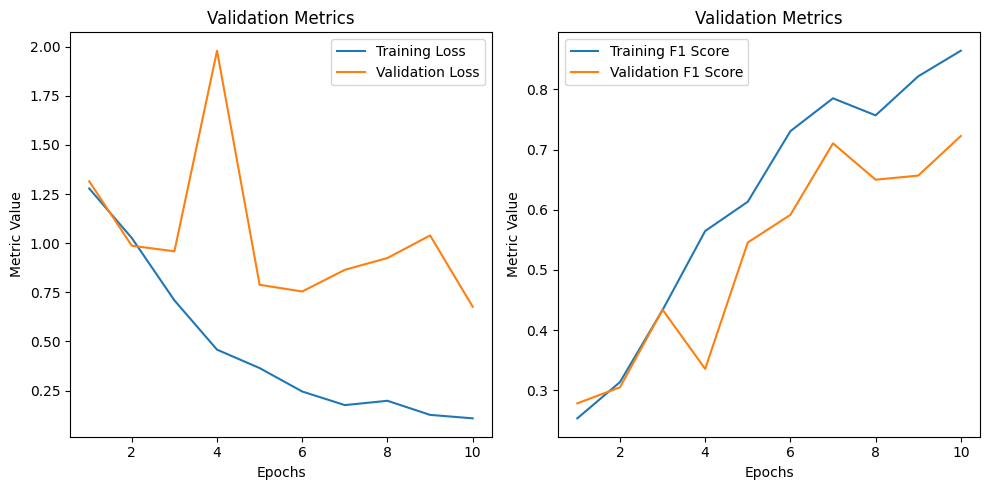

In [16]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model, test_dataloader, device)

print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Convert metric history to a DataFrame
metric_df = pd.DataFrame(metric_history)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join('checkpoints/', f'{model_name}_metrics.csv')
if not os.path.exists(csv_file_path):
    metric_df.to_csv(csv_file_path, index=False)

plot_metrics_from_csv(model_name, title='Validation Metrics', ylabel='Metric Value')

In [17]:
del model
torch.cuda.empty_cache()

In [18]:
import timm
import torch.nn as nn
import torch.optim as optim

# Load the Vision Transformer model
model2 = timm.create_model('vit_small_patch16_224', pretrained=False)
summary(model2, (3, 224, 224))

# Modify the final layer to match the number of classes (4 in this case)
num_features = model2.head.in_features
model2.head = nn.Linear(num_features, 4)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model2.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)

# Train the model
metric_history = {'val_loss': [], 'val_f1': [], 'train_loss': [], 'train_f1': []}
model_name='vit_small_patch16_224'
model2 = train_model(model2, model_name='vit_small_patch16_224_w_crossentropy', num_epochs=15)

d:\DL\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Layer (type:depth-idx)                   Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 196, 384]            --
|    └─Conv2d: 2-1                       [-1, 384, 14, 14]         295,296
|    └─Identity: 2-2                     [-1, 196, 384]            --
├─Dropout: 1-2                           [-1, 197, 384]            --
├─Identity: 1-3                          [-1, 197, 384]            --
├─Identity: 1-4                          [-1, 197, 384]            --
├─Sequential: 1-5                        [-1, 197, 384]            --
|    └─Block: 2-3                        [-1, 197, 384]            --
|    |    └─LayerNorm: 3-1               [-1, 197, 384]            768
|    |    └─Attention: 3-2               [-1, 197, 384]            591,360
|    |    └─Identity: 3-3                [-1, 197, 384]            --
|    |    └─Identity: 3-4                [-1, 197, 384]            --
|    |    └─LayerNorm: 3-5               [-1, 197, 384]            768
|  

d:\DL\env\Lib\site-packages\timm\models\vision_transformer.py:86: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


[[3439  440 1178    0]
 [ 367   78  112    0]
 [ 119   13   44    0]
 [  40    0    8    0]]
Overall Accuracy: 0.6099691675231244
Accuracy for Class 0: 0.6800474589677674
Accuracy for Class 1: 0.1400359066427289
Accuracy for Class 2: 0.25
Accuracy for Class 3: 0.0
F1 Score: 0.6757990249667136
Recall: 0.6099691675231244
Precision: 0.7663110871997832


d:\DL\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


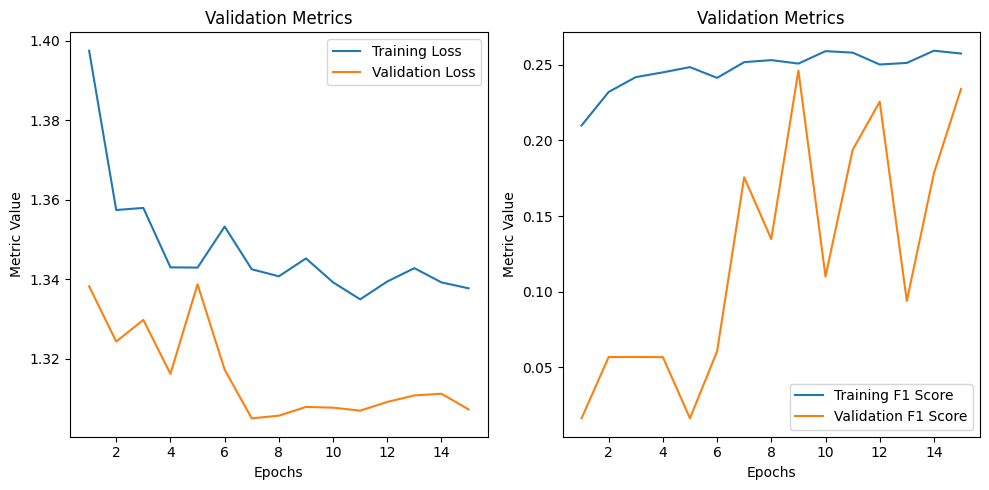

In [19]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model2, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Convert metric history to a DataFrame
metric_df = pd.DataFrame(metric_history)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join('checkpoints/', f'{model_name}_metrics.csv')
if not os.path.exists(csv_file_path):
    metric_df.to_csv(csv_file_path, index=False)

plot_metrics_from_csv(model_name, title='Validation Metrics', ylabel='Metric Value')

In [20]:
del model2
torch.cuda.empty_cache()

In [21]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize the images to 299x299
])

# Load the Inception v3 model
model3 = models.inception_v3(weights=None)
summary(model3, (3, 299, 299))

# Modify the final layer to match the number of classes (4 in this case)
# Inception v3 has an auxiliary output, so we need to modify both the main and auxiliary classifiers
num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features,4)

num_features_aux = model3.AuxLogits.fc.in_features
model3.AuxLogits.fc = nn.Linear(num_features_aux, 4)

# Define the loss function and optimizer
criterion = HierarchicalCrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model3.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)

# Train the model
metric_history = {'val_loss': [], 'val_f1': [], 'train_loss': [], 'train_f1': []}
model_name='inception_v3_w_crossentropy'
model3 = train_model(model3, transform=transform, model_name=model_name, num_epochs=15)

d:\DL\env\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 149, 149]        --
|    └─Conv2d: 2-1                       [-1, 32, 149, 149]        864
|    └─BatchNorm2d: 2-2                  [-1, 32, 149, 149]        64
├─BasicConv2d: 1-2                       [-1, 32, 147, 147]        --
|    └─Conv2d: 2-3                       [-1, 32, 147, 147]        9,216
|    └─BatchNorm2d: 2-4                  [-1, 32, 147, 147]        64
├─BasicConv2d: 1-3                       [-1, 64, 147, 147]        --
|    └─Conv2d: 2-5                       [-1, 64, 147, 147]        18,432
|    └─BatchNorm2d: 2-6                  [-1, 64, 147, 147]        128
├─MaxPool2d: 1-4                         [-1, 64, 73, 73]          --
├─BasicConv2d: 1-5                       [-1, 80, 73, 73]          --
|    └─Conv2d: 2-7                       [-1, 80, 73, 73]          5,120
|    └─BatchNorm2d: 2-8                  [-1, 80, 73, 73]          160
├─

[[2881  879 1202   95]
 [  85  409   56    7]
 [   6   24  143    3]
 [   2    7    6   33]]
Overall Accuracy: 0.5936964713943131
Accuracy for Class 0: 0.5697053589084438
Accuracy for Class 1: 0.7342908438061041
Accuracy for Class 2: 0.8125
Accuracy for Class 3: 0.6875
F1 Score: 0.6714535652228014
Recall: 0.5936964713943131
Precision: 0.8737486967872453


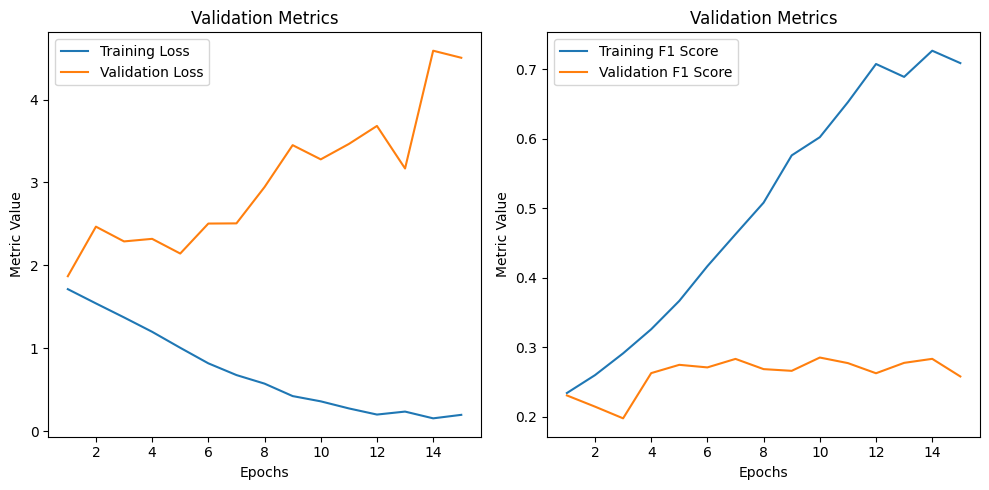

In [22]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model3, test_dataloader, device, transform=transform)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Convert metric history to a DataFrame
metric_df = pd.DataFrame(metric_history)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join('checkpoints/', f'{model_name}_metrics.csv')
if not os.path.exists(csv_file_path):
    metric_df.to_csv(csv_file_path, index=False)

plot_metrics_from_csv(model_name, title='Validation Metrics', ylabel='Metric Value')

In [23]:
del model3
torch.cuda.empty_cache()

### Custom Models

Here are our custom models.

In [24]:
# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet, self).__init__()
#         self.encoder1 = self.conv_block(in_channels, 64)
#         self.encoder2 = self.conv_block(64, 128)
#         self.decoder1 = self.conv_block(128, 64)
#         self.decoder2 = self.conv_block(64, out_channels)

#     def conv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         x1 = self.encoder1(x)
#         x2 = self.encoder2(x1)
#         x = self.decoder1(x2)
#         x = self.decoder2(x + x1)
#         return x

# class ParallelModel_UNet_EffNet(nn.Module):
#     def __init__(self, num_classes, efficientnet_model='efficientnet-b0', unet_layers=3):
#         super(ParallelModel_UNet_EffNet, self).__init__()
#         self.unet = UNet(3, num_classes)
#         self.efficientnet = models.efficientnet_b0()
#         # Remove the fully connected layer and global average pooling layer
#         self.efficientnet = nn.Sequential(*(list(self.efficientnet.children())[:-2]))

#         # Adaptive pooling layer to resize EfficientNet output
#         self.adaptive_pool = nn.AdaptiveAvgPool2d((224, 224))

#         # Add a global average pooling layer to reduce spatial dimensions
#         self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

#         # Final layers
#         self.conv = nn.Conv2d(num_classes + 1280, num_classes, kernel_size=1)

#     def forward(self, x):
#         unet_output = self.unet(x)
#         efficientnet_output = self.efficientnet(x)
#         # Resize EfficientNet output to match U-Net output dimensions
#         efficientnet_output = self.adaptive_pool(efficientnet_output)
        
#         # Concatenate along the channel dimension
#         combined = torch.cat((unet_output, efficientnet_output), dim=1)

#         # Apply global average pooling to reduce to shape [batch_size, num_channels]
#         combined = self.global_avg_pool(combined)
#         combined = combined.view(combined.size(0), -1)  # Flatten

#         # Apply final layers
#         out = self.conv(combined.unsqueeze(-1).unsqueeze(-1))  # Add back spatial dimensions for Conv2d
#         out = out.squeeze(-1).squeeze(-1)  # Remove spatial dimensions after Conv2d
#         return out


In [25]:
# ##Train
# # Load model4
# model4 = ParallelModel_UNet_EffNet(num_classes=4)

# summary(model4, (3, 224, 224))

# ## Define the loss function and optimizer
# # criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# # Use the hierarchical cross-entropy loss function
# criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# optimizer = optim.Adam(model4.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)

# # Train the model
# metric_history = {'val_loss': [], 'val_f1': [], 'train_loss': [], 'train_f1': []}
# model_name='ParallelModel_UNet_EffNet_w_crossentropy'
# model4 = train_model(model4, model_name=model_name, num_epochs=15)

In [26]:
# ## Evaluate
# overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model4, test_dataloader, device)
# print(f'Overall Accuracy: {overall_accuracy}')
# for i, class_accuracy in enumerate(class_accuracies):
#     print(f'Accuracy for Class {i}: {class_accuracy}')
# print(f'F1 Score: {f1}')
# print(f'Recall: {recall}')
# print(f'Precision: {precision}')

# # Convert metric history to a DataFrame
# metric_df = pd.DataFrame(metric_history)

# # Save the DataFrame to a CSV file
# if not os.path.exists(csv_file_path):
#     csv_file_path = os.path.join('checkpoints/', f'{model_name}_metrics.csv')
#     metric_df.to_csv(csv_file_path, index=False)

# plot_metrics_from_csv(model_name, title='Validation Metrics', ylabel='Metric Value')

In [27]:
# del model4
# torch.cuda.empty_cache()

In [28]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(
#             in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
#                                stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = nn.ReLU()(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = nn.ReLU()(out)
#         return out

# class ResNet9(nn.Module):
#     def __init__(self, num_classes=4):
#         super(ResNet9, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
#                                stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(BasicBlock, 64, 1, stride=1)
#         self.layer2 = self._make_layer(BasicBlock, 128, 1, stride=2)
#         self.layer3 = self._make_layer(BasicBlock, 256, 1, stride=2)
#         self.layer4 = self._make_layer(BasicBlock, 512, 1, stride=2)
#         self.linear = nn.Linear(512*BasicBlock.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = nn.ReLU()(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = nn.AdaptiveAvgPool2d((1, 1))(out)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out
    
# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet, self).__init__()
#         self.encoder1 = self.conv_block(in_channels, 64)
#         self.encoder2 = self.conv_block(64, 128)
#         self.decoder1 = self.conv_block(128, 64)
#         self.decoder2 = self.conv_block(64, out_channels)

#     def conv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         x1 = self.encoder1(x)
#         x2 = self.encoder2(x1)
#         x = self.decoder1(x2)
#         x = self.decoder2(x + x1)
#         return x

# class ParallelModel_UNet_ResNet(nn.Module):
#     def __init__(self, num_classes, unet_layers=3):
#         super(ParallelModel_UNet_ResNet, self).__init__()
#         self.unet = UNet(3, num_classes)
#         self.resnet = ResNet9()
#         # Remove the fully connected layer and global average pooling layer from ResNet9
#         self.resnet = nn.Sequential(*(list(self.resnet.children())[:-1]))

#         # Adaptive pooling layer to resize ResNet9 output
#         self.adaptive_pool = nn.AdaptiveAvgPool2d((224, 224))

#         # Add a global average pooling layer to reduce spatial dimensions
#         self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

#         # Final layers
#         self.conv = nn.Conv2d(num_classes + 512, num_classes, kernel_size=1)

#     def forward(self, x):
#         unet_output = self.unet(x)
#         resnet_output = self.resnet(x)
#         # print(unet_output.shape, resnet_output.shape)

#         # Resize ResNet9 output to match U-Net output dimensions
#         resnet_output = self.adaptive_pool(resnet_output)
#         # Concatenate along the channel dimension
#         combined = torch.cat((unet_output, resnet_output), dim=1)

#         # Apply global average pooling to reduce to shape [batch_size, num_channels]
#         combined = self.global_avg_pool(combined)
#         combined = combined.view(combined.size(0), -1)  # Flatten

#         # Apply final layers
#         out = self.conv(combined.unsqueeze(-1).unsqueeze(-1))  # Add back spatial dimensions for Conv2d
#         out = out.squeeze(-1).squeeze(-1)  # Remove spatial dimensions after Conv2d
#         return out


In [29]:
# ##Train
# # Load model5
# model5 = ParallelModel_UNet_ResNet(num_classes=4)

# summary(model5, (3, 224, 224))

# ## Define the loss function and optimizer
# # criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# # Use the hierarchical cross-entropy loss function
# criterion = HierarchicalCrossEntropyLoss(weight=weights_tensor)
# optimizer = optim.Adam(model5.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)
# model5 = train_model(model5, num_epochs=15, model_name='ParallelModel_UNet_ResNet')

In [30]:
# ## Evaluate
# overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model5, test_dataloader, device)
# print(f'Overall Accuracy: {overall_accuracy}')
# for i, class_accuracy in enumerate(class_accuracies):
#     print(f'Accuracy for Class {i}: {class_accuracy}')
# print(f'F1 Score: {f1}')
# print(f'Recall: {recall}')
# print(f'Precision: {precision}')

In [31]:
# del model5
# torch.cuda.empty_cache()

In [32]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet9, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 1, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 1, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 1, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 1, stride=2)
        self.linear = nn.Linear(512*BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.decoder1 = self.conv_block(128, 64)
        self.decoder2 = self.conv_block(64, out_channels)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x = self.decoder1(x2)
        x = self.decoder2(x + x1)
        return x
    
class SequentialModel_UNet_ResNet(nn.Module):
    def __init__(self, num_classes, resnet_layers=9, unet_layers=3):
        super(SequentialModel_UNet_ResNet, self).__init__()
        self.unet = UNet(3, 64)  # Assuming U-Net's output channels are 64
        if resnet_layers == 9:
            self.resnet = ResNet9(num_classes=num_classes)

        # Modify ResNet to accept U-Net's output as input
        self.resnet.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.bn1 = nn.BatchNorm2d(64)

    def forward(self, x):
        unet_output = self.unet(x)
        resnet_output = self.resnet(unet_output)
        return resnet_output


In [33]:
##Train
# Load model6
model6 = SequentialModel_UNet_ResNet(num_classes=4)

summary(model6, (3, 224, 224))

## Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# Use the hierarchical cross-entropy loss function
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model6.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)

# Train the model
metric_history = {'val_loss': [], 'val_f1': [], 'train_loss': [], 'train_f1': []}
model_name='SequentialModel_UNet_ResNet'
model6 = train_model(model6, model_name=model_name, num_epochs=100, early_stopping=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─UNet: 1-1                              [-1, 64, 224, 224]        --
|    └─Sequential: 2-1                   [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 224, 224]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-3                  [-1, 64, 224, 224]        36,928
|    |    └─ReLU: 3-4                    [-1, 64, 224, 224]        --
|    └─Sequential: 2-2                   [-1, 128, 224, 224]       --
|    |    └─Conv2d: 3-5                  [-1, 128, 224, 224]       73,856
|    |    └─ReLU: 3-6                    [-1, 128, 224, 224]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 224, 224]       147,584
|    |    └─ReLU: 3-8                    [-1, 128, 224, 224]       --
|    └─Sequential: 2-3                   [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-9                  [-1, 64, 224, 224]        73

[[4969   76    7    5]
 [ 100  454    3    0]
 [  34    5  137    0]
 [   5    0    1   42]]
Overall Accuracy: 0.9595751969852689
Accuracy for Class 0: 0.982598378485268
Accuracy for Class 1: 0.8150807899461401
Accuracy for Class 2: 0.7784090909090909
Accuracy for Class 3: 0.875
F1 Score: 0.958975263033808
Recall: 0.9595751969852689
Precision: 0.9588676803428244


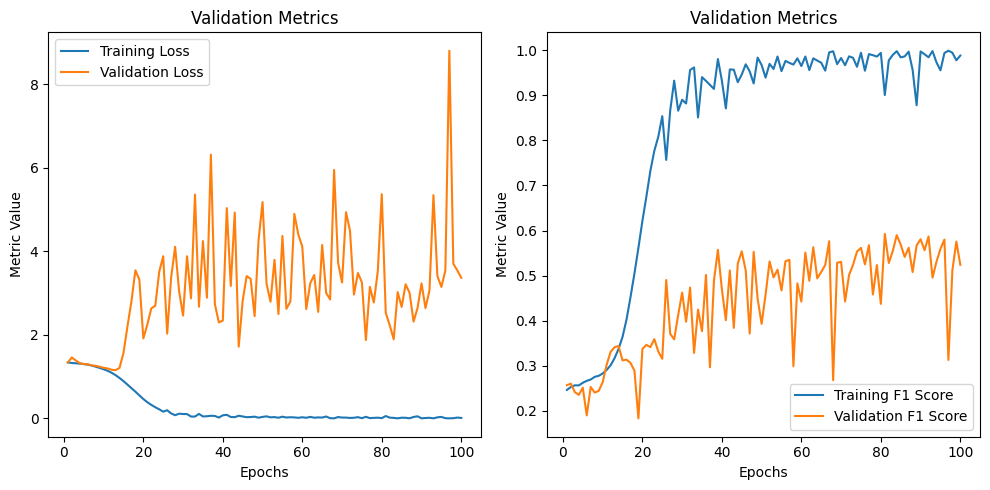

In [34]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model6, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Convert metric history to a DataFrame
metric_df = pd.DataFrame(metric_history)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join('checkpoints/', f'{model_name}_metrics.csv')
if not os.path.exists(csv_file_path):
    metric_df.to_csv(csv_file_path, index=False)
else:
    metric_df.to_csv(csv_file_path, mode='a', header=False, index=False)

plot_metrics_from_csv(model_name, title='Validation Metrics', ylabel='Metric Value')

In [35]:
# del model6
# torch.cuda.empty_cache()

In [36]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

import torch
import torch.nn as nn
import torchvision.models as models

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class UNet_with_ResNet_Blocks(nn.Module):
    def __init__(self, num_classes):
        super(UNet_with_ResNet_Blocks, self).__init__()
        self.encoder1 = ResNetBlock(3, 64)
        self.pool = nn.MaxPool2d(2, 2)
        self.encoder2 = ResNetBlock(64, 128)
        self.bottleneck = ResNetBlock(128, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = ResNetBlock(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = ResNetBlock(128, 64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        x = self.pool(enc1)
        enc2 = self.encoder2(x)
        x = self.pool(enc2)
        x = self.bottleneck(x)
        x = self.upconv2(x)
        x = torch.cat((x, enc2), dim=1)
        x = self.decoder2(x)
        x = self.upconv1(x)
        x = torch.cat((x, enc1), dim=1)
        x = self.decoder1(x)

        # Classification
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [37]:
##Train
# Load model7
model7 = UNet_with_ResNet_Blocks(num_classes=4)

summary(model7, (3, 224, 224))

## Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model7.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)

# Train the model
metric_history = {'val_loss': [], 'val_f1': [], 'train_loss': [], 'train_f1': []}
model_name='UNet_with_ResNet_Blocks_w_crossentropy'
model7 = train_model(model7, model_name=model_name, num_epochs=100, early_stopping=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetBlock: 1-1                       [-1, 64, 224, 224]        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,728
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        36,864
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        128
|    └─Sequential: 2-6                   [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 224, 224]        192
|    |    └─BatchNorm2d: 3-2             [-1, 64, 224, 224]        128
|    └─ReLU: 2-7                         [-1, 64, 224, 224]        --
├─MaxPool2d: 1-2                         [-1, 64, 112, 112]        --
├─ResNetBlock: 1-3                       [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       73,728


[[5008   46    3    0]
 [  60  495    1    1]
 [  32    4  139    1]
 [   7    0    0   41]]
Overall Accuracy: 0.973449811579308
Accuracy for Class 0: 0.9903104607474787
Accuracy for Class 1: 0.8886894075403949
Accuracy for Class 2: 0.7897727272727273
Accuracy for Class 3: 0.8541666666666666
F1 Score: 0.97300210468381
Recall: 0.973449811579308
Precision: 0.9732293089050247


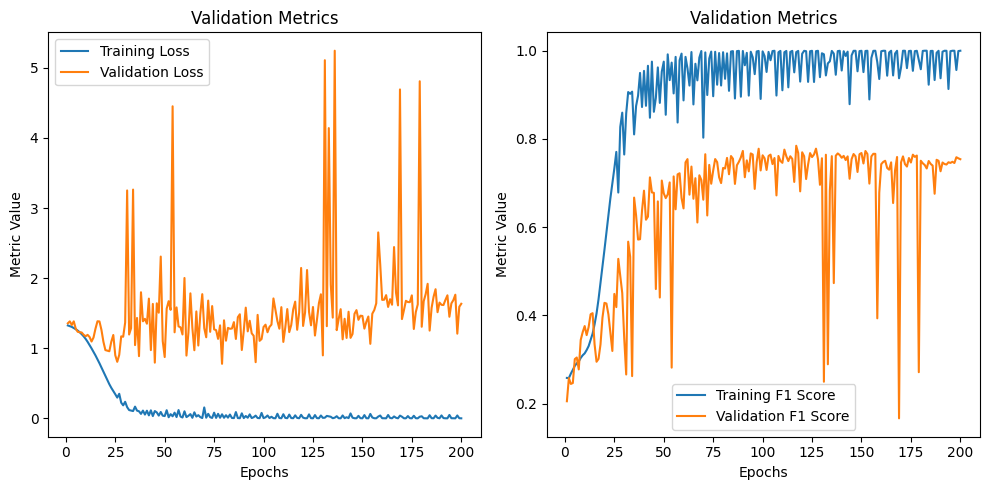

In [38]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model7, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Convert metric history to a DataFrame
metric_df = pd.DataFrame(metric_history)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join('checkpoints/', f'{model_name}_metrics.csv')
if not os.path.exists(csv_file_path):
    metric_df.to_csv(csv_file_path, index=False)
else:
    metric_df.to_csv(csv_file_path, mode='a', header=False, index=False)

plot_metrics_from_csv(model_name, title='Validation Metrics', ylabel='Metric Value')

In [39]:
##Train
# Load model7
model7 = UNet_with_ResNet_Blocks(num_classes=4)

summary(model7, (3, 224, 224))

## Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model7.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)

# Train the model
metric_history = {'val_loss': [], 'val_f1': [], 'train_loss': [], 'train_f1': []}
model_name='UNet_with_ResNet_Blocks_w_crossentropy_finetuned_w_hierachical'
model7 = train_model(model7, model_name=model_name, num_epochs=100, early_stopping=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetBlock: 1-1                       [-1, 64, 224, 224]        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,728
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        36,864
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        128
|    └─Sequential: 2-6                   [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 224, 224]        192
|    |    └─BatchNorm2d: 3-2             [-1, 64, 224, 224]        128
|    └─ReLU: 2-7                         [-1, 64, 224, 224]        --
├─MaxPool2d: 1-2                         [-1, 64, 112, 112]        --
├─ResNetBlock: 1-3                       [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       73,728


[[4990   30   32    5]
 [  67  487    3    0]
 [  20    7  149    0]
 [   4    1    1   42]]
Overall Accuracy: 0.9708804385063378
Accuracy for Class 0: 0.9867510381649199
Accuracy for Class 1: 0.874326750448833
Accuracy for Class 2: 0.8465909090909091
Accuracy for Class 3: 0.875
F1 Score: 0.9707635149785501
Recall: 0.9708804385063378
Precision: 0.9708390912200696


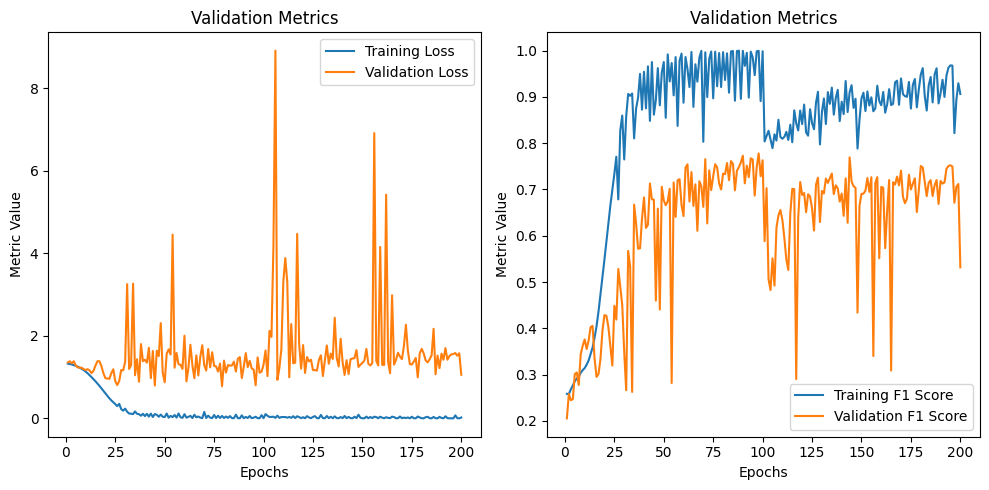

In [40]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model7, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Convert metric history to a DataFrame
metric_df = pd.DataFrame(metric_history)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join('checkpoints/', f'{model_name}_metrics.csv')
if not os.path.exists(csv_file_path):
    metric_df.to_csv(csv_file_path, index=False)
else:
    metric_df.to_csv(csv_file_path, mode='a', header=False, index=False)

plot_metrics_from_csv(model_name, title='Validation Metrics', ylabel='Metric Value')

In [41]:
del model7
torch.cuda.empty_cache()

In [42]:
##Train
# Load model12
model12 = VGG_Attention(num_classes=4)

summary(model12, (3, 224, 224))

## Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model12.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)
 
# Train the model
metric_history = {'val_loss': [], 'val_f1': [], 'train_loss': [], 'train_f1': []}
model_name='VGG_Attention'
model12 = train_model(model12, model_name=model_name, num_epochs=10, early_stopping=False)

NameError: name 'VGG_Attention' is not defined

[[4992    0    0    0]
 [ 602    0    0    0]
 [ 208    0    0    0]
 [  36    0    0    0]]
Overall Accuracy: 0.8550873586844809
Accuracy for Class 0: 1.0
Accuracy for Class 1: 0.0
Accuracy for Class 2: 0.0
Accuracy for Class 3: 0.0
F1 Score: 0.7882910608592667
Recall: 0.8550873586844809
Precision: 0.7311743909820022


d:\DL\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


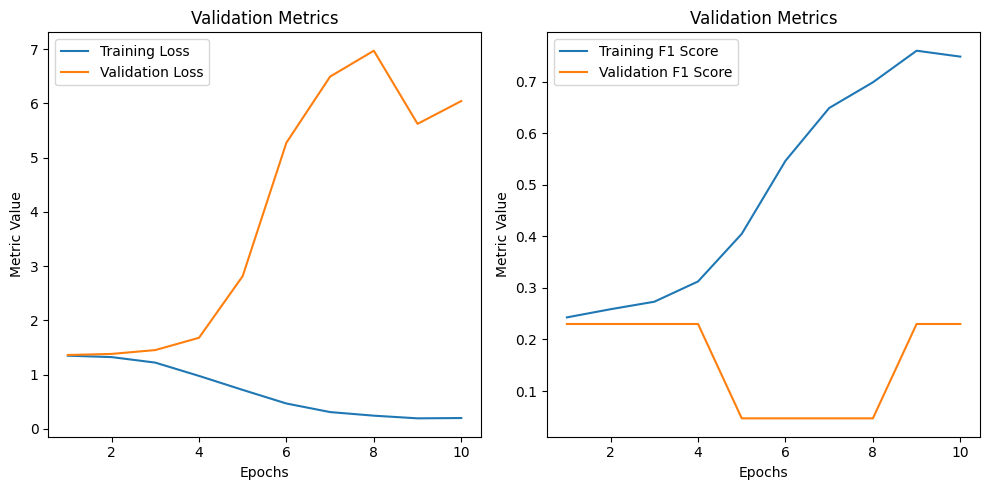

In [ ]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model12, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Convert metric history to a DataFrame
metric_df = pd.DataFrame(metric_history)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join('checkpoints/', f'{model_name}_metrics.csv')
if not os.path.exists(csv_file_path):
    metric_df.to_csv(csv_file_path, index=False)
else:
    metric_df.to_csv(csv_file_path, mode='a', header=False, index=False)

plot_metrics_from_csv(model_name, title='Validation Metrics', ylabel='Metric Value')

In [ ]:
del model12
torch.cuda.empty_cache()